In [1]:
import sys
from pathlib import Path
notebook_dir = Path('/home/chan21/idiosyncratic-neural-geometry/notebooks')
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
    
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

import os
from abc import ABC, abstractmethod
import h5py
import numpy as np
from typing import Dict, List, Optional, Tuple, Any, Union
from pathlib import Path
from scipy import stats
from dataclasses import dataclass
from src.utils._config import *
from src.utils._io import *
from src.utils.plot import *
from src.utils.binning import *
from src.spectra._definition import *
from src.idm._definition import *
import argparse
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm


In [3]:
rois = ['occipital', 'ventral', 'temporal', 'dmn']
rois_names = {'occipital': 'early',
              'ventral': 'ventral',
              'temporal': 'lateral',
              'dmn': 'parietal-cingulate'}

HOME_DIR = Path("/data/chan21/idiosyncratic-neural-geometry/")
idm_roi_colors = sns.color_palette("magma", len(rois))

DEFAULT = {
    "figure.facecolor": "None",
    "axes.facecolor": "None",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "xtick.minor.visible": False,
    "ytick.minor.visible": False,
    "patch.linewidth": 0,
    "xtick.minor.size": 0,
    "ytick.minor.size": 0,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "axes.labelsize": 24, 
}
sns.set_theme(style="ticks", rc=DEFAULT)
bin_strategy = BinStrategy(
            type='logarithmic',
            density=3,
            start=1,
            stop=10_000
        )

roi_corrs = {}
roi_corrs_isc = {}
roi_split_corrs = {}
roi_split_corrs_isc = {}

roi_perm_corrs = {roi: [] for roi in rois}
roi_perm_corrs_isc = {roi: [] for roi in rois}
roi_perm_split_corrs = {roi: [] for roi in rois}
roi_perm_split_corrs_isc = {roi: [] for roi in rois}

roi_boot_corrs = {roi: [] for roi in rois}
roi_boot_corrs_isc = {roi: [] for roi in rois}
roi_split_boot_corrs = {roi: [] for roi in rois}
roi_split_boot_corrs_isc = {roi: [] for roi in rois}
significance_isc = {roi: [] for roi in rois}
significance = {roi: [] for roi in rois}

In [5]:
def get_min_length(h5_data_path, subjects, movies):
    try:
        with h5py.File(h5_data_path, 'r') as h5f:
            min_length = np.min([
                h5f[f"data/sub-NSD103_sub-NSD104_{movie}"]["observed"].shape[0] 
                for movie in movies
            ])
        return min_length
    except Exception as e:
        print(f"Error calculating min_length: {e}")
        # Return a default value or raise exception
        raise

def compute_idm_fp(args, movie=None):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    analysis = IDMAnalysis(cache, bin_strategy)
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path

    min_length = get_min_length(h5_data_path, subjects, movies)
    indices=np.arange(min_length)
    bin_assignments = [assign_data_to_geometrically_spaced_bins(
        index + 1,
        density=3,
        start=1,
        stop=10_000) for index in indices]
    unique_bins = np.unique(bin_assignments)
    
    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
    else:
        motion_matrices = nuisance_matrices.get('motion', {})


    if movie is not None:
        idms = []
        for movie in config.movies:
            all_spectra = np.zeros((n_subjects, n_subjects, len(unique_bins)))
            with h5py.File(h5_data_path, 'r') as h5f:
                for i, i_subject in enumerate(subjects):
                    for j, j_subject in enumerate(subjects[i+1:], i+1):
                        spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                        for n_bin, bin_id in enumerate(unique_bins):
                            all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                            all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                idms.append(np.moveaxis(all_spectra, -1, 0))
        return analysis, idms, anat_matrices

    even_movies = config.movies[::2]
    odd_movies = config.movies[1::2]
    even_anat = np.nanmean([anat_matrices[m] for m in even_movies], axis=0) if anat_matrices else None       
    odd_anat = np.nanmean([anat_matrices[m] for m in odd_movies], axis=0) if anat_matrices else None

    idm_series = {}
    with h5py.File(h5_data_path, 'r') as h5f:
        # Initialize array to store all spectra    
        for movie in movies:
            all_spectra = np.zeros((n_subjects, n_subjects, len(unique_bins)))
            # Load spectra for each subject pair
            for i, i_subject in enumerate(subjects):
                for j, j_subject in enumerate(subjects[i+1:], i+1):
                    spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                    for n_bin, bin_id in enumerate(unique_bins):
                        try:
                            all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                            all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                        except Exception as e:
                            continue
            idm_series[movie] = all_spectra

    idm_even_series = np.nanmean([idm_series[movie] for movie in movies[::2]], axis=0)
    idm_odd_series = np.nanmean([idm_series[movie] for movie in movies[1::2]], axis=0)
    
    even_idm, odd_idm = np.moveaxis(idm_even_series, -1, 0), np.moveaxis(idm_odd_series, -1, 0)
    if args.motion:
        return analysis, even_idm, odd_idm, even_anat, odd_anat, motion_matrices, unique_bins
    else:
        return analysis, even_idm, odd_idm, even_anat, odd_anat, unique_bins


for roi in rois:
    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/idiosyncratic-neural-geometry/results/",
        motion_type=["ISC", "AnnaK"],
        isc=True,
        isc_dir=f"/data/chan21/idiosyncratic-neural-geometry/results/isc_{roi}_functional/eigenspectra.h5", 
        anatomical=False,
    )

    analysis, even_idm, odd_idm, even_anat, odd_anat, motion_matrices, unique_bins = compute_idm_fp(args)
    movies = list(motion_matrices[0].keys())
    even_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[::2]], axis=0)
    odd_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[1::2]], axis=0)
    even_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[::2]], axis=0)
    odd_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[1::2]], axis=0)

    if args.isc:
        n_bins = len(even_idm)
        correlations = []
        residual1 = []
        residual2 = []
        for n_bin in range(n_bins):
            _, rx, ry = analysis._fully_partial_correlation(
                get_upper_triangle(even_idm[n_bin]),
                get_upper_triangle(odd_idm[n_bin]),
                get_upper_triangle(even_motion1),
                get_upper_triangle(odd_motion1))
            _, rx, ry = analysis._fully_partial_correlation(
                rx,
                ry,
                get_upper_triangle(even_motion2),
                get_upper_triangle(odd_motion2))
            corr, res1, res2 = analysis._fully_partial_correlation(
                rx,
                ry,
                get_upper_triangle(even_anat),
                get_upper_triangle(odd_anat))
            correlations.append(corr)
            residual1.append(res1)
            residual2.append(res2)
        roi_corrs_isc[roi] = correlations
        diagonals = np.zeros((len(correlations), len(correlations)))
        for i, corr in enumerate(correlations):
            residual1_tri = residual1[i]
            for j, c in enumerate(correlations):
                diagonals[i, j] = np.corrcoef(residual1_tri, residual2[j])[0, 1]
        roi_split_corrs_isc[roi] = diagonals
    else:
        n_bins = len(even_idm)
        correlations = []
        residual1 = []
        residual2 = []
        for n_bin in range(n_bins):
            _, rx, ry = analysis._fully_partial_correlation(
                get_upper_triangle(even_idm[n_bin]),
                get_upper_triangle(odd_idm[n_bin]),
                get_upper_triangle(even_motion1),
                get_upper_triangle(odd_motion1))
            corr, rx, ry = analysis._fully_partial_correlation(
                rx,
                ry,
                get_upper_triangle(even_motion2),
                get_upper_triangle(odd_motion2))
            correlations.append(corr)
            residual1.append(rx)
            residual2.append(ry)
        roi_corrs[roi] = correlations
        diagonals = np.zeros((len(correlations), len(correlations)))
        for i, corr in enumerate(correlations):
            residual1_tri = residual1[i]
            for j, c in enumerate(correlations):
                diagonals[i, j] = np.corrcoef(residual1_tri, residual2[j])[0, 1]
        roi_split_corrs[roi] = diagonals




In [7]:
def bootstrap_idm_series(analysis, args, n_bootstraps=1000):
    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    assert config.roi_names[0] == args.roi
    assert config.metric == args.metric

    config.data_path = ANALYSIS_DIR / "eigenspectra.h5"
    cache_dir = HOME_DIR / "data" / "cache" / f"idm_{args.roi}_{args.metric}"
    if not cache_dir.exists():
        cache_dir.mkdir(parents=True)

    cache = DataCache(
        cache_dir = cache_dir,
        enabled=False,
        )
    movies = config.movies
    subjects = config.subjects
    n_subjects = len(subjects)
    h5_data_path = config.data_path

    min_length = get_min_length(h5_data_path, subjects, movies)
    indices=np.arange(min_length)
    bin_assignments = [assign_data_to_geometrically_spaced_bins(
        index + 1,
        density=3,
        start=1,
        stop=10_000) for index in indices]
    unique_bins = np.unique(bin_assignments)

    ANALYSIS_DIR = HOME_DIR / "results" / args.dir
    config = AnalysisConfig.from_yaml(ANALYSIS_DIR / "config.yaml")
    nuisance_matrices, _ = create_nuisance_matrices(args, config)    
    anat_matrices = nuisance_matrices.get('anatomical', {})
    even_movies = config.movies[::2]
    odd_movies = config.movies[1::2]
    even_anat = np.nanmean([anat_matrices[m] for m in even_movies], axis=0) if anat_matrices else None       
    odd_anat = np.nanmean([anat_matrices[m] for m in odd_movies], axis=0) if anat_matrices else None
    if type(args.motion_type) == list:
        motion_matrices = []
        for motion in args.motion_type:
            motion_matrices.append(nuisance_matrices.get(f"motion_{motion}", {}))
        even_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[::2]], axis=0)
        odd_motion1 = np.nanmean([motion_matrices[0][m] for m in movies[1::2]], axis=0)
        even_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[::2]], axis=0)
        odd_motion2 = np.nanmean([motion_matrices[1][m] for m in movies[1::2]], axis=0)
    else:
        motion_matrices = nuisance_matrices.get('motion', {})
        even_motion1 = np.nanmean([motion_matrices[m] for m in movies[::2]], axis=0)
        odd_motion1 = np.nanmean([motion_matrices[m] for m in movies[1::2]], axis=0)
            
    n_bins = len(unique_bins)

    bootstrapped_correlations = [] 
    for boot_idx in tqdm(range(n_bootstraps)):
        if args.isc:
            file = f"{HOME_DIR}/data/cache/idm_{args.roi}_{args.metric}/{args.roi}_{args.metric}_bootstrapped90_fp_isc_{str(boot_idx)}.pkl"
        else:
            file = f"{HOME_DIR}/data/cache/idm_{args.roi}_{args.metric}/{args.roi}_{args.metric}_bootstrapped90_{str(boot_idx)}.pkl"
        if os.path.exists(file):
            with open(file, "rb") as f:
                bootstrapped_series, subject_idx = pickle.load(f)
            boot_idm1 = np.nanmean([bootstrapped_series[movie] for movie in even_movies], axis=0)
            boot_idm2 = np.nanmean([bootstrapped_series[movie] for movie in config.movies[1::2]], axis=0)
            boot_idm1 = np.moveaxis(boot_idm1, -1, 0)
            boot_idm2 = np.moveaxis(boot_idm2, -1, 0)
            bootstrapped_even_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_odd_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_even_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_odd_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                        bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                        bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                        bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                        bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
                    elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                        bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                        bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                        bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                        bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
            if args.isc:
                bootstrapped_even_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
                bootstrapped_odd_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
                for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                        if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                            bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                            bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                            bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                            bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
                        elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                            bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                            bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                            bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                            bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
                corr = np.zeros((n_bins))
                for n_bin in range(n_bins):
                    _, rx, ry = analysis._fully_partial_correlation(
                        get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                        get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                        get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                    _, rx, ry = analysis._fully_partial_correlation(
                        rx,
                        ry,
                        get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                    r, _, _ = analysis._fully_partial_correlation(
                        rx,
                        ry,
                        get_filtered_upper_triangle(bootstrapped_even_anat, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_anat, subject_idx))
                    corr[n_bin] = r
            else: 
                corr = np.zeros((n_bins))
                for n_bin in range(n_bins):
                    _, rx, ry = analysis._fully_partial_correlation(
                        get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                        get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                        get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                    r, rx, ry = analysis._fully_partial_correlation(
                        rx,
                        ry,
                        get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                        get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                    corr[n_bin] = r
            bootstrapped_correlations.append(corr)
            continue
        
        bootstrapped_series = {}
        subject_idx = np.random.choice(n_subjects, size=int(n_subjects*0.9), replace=True)
        if anat_matrices:
            bootstrapped_even_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            bootstrapped_odd_anat = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
            for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                        bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                        bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                        bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
                    elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                        bootstrapped_even_anat[i, j] = even_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_even_anat[j, i] = bootstrapped_even_anat[i, j]
                        bootstrapped_odd_anat[i, j] = odd_anat[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                        bootstrapped_odd_anat[j, i] = bootstrapped_odd_anat[i, j]
        with h5py.File(h5_data_path, 'r') as h5f:
            for movie in movies:
                all_spectra = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9), len(unique_bins)))
                for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
                    for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                        if i_subject != j_subject:
                            try:
                                spectrum = h5f[f"data/{i_subject}_{j_subject}_{movie}"]["observed"][:min_length]
                            except:
                                spectrum = h5f[f"data/{j_subject}_{i_subject}_{movie}"]["observed"][:min_length]
                            for n_bin, bin_id in enumerate(unique_bins):
                                try:
                                    all_spectra[i, j, n_bin] = spectrum[bin_assignments == bin_id].mean()
                                except:
                                    continue                              
                                #all_spectra[j, i, n_bin] = all_spectra[i, j, n_bin]
                bootstrapped_series[movie] = all_spectra
        
        with open(file, "wb") as f:
            pickle.dump((bootstrapped_series, subject_idx), f)

        boot_idm1 = np.nanmean([bootstrapped_series[movie] for movie in even_movies], axis=0)
        boot_idm2 = np.nanmean([bootstrapped_series[movie] for movie in config.movies[1::2]], axis=0)
        boot_idm1 = np.moveaxis(boot_idm1, -1, 0)
        boot_idm2 = np.moveaxis(boot_idm2, -1, 0)
        bootstrapped_even_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        bootstrapped_odd_motion1 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        bootstrapped_even_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        bootstrapped_odd_motion2 = np.zeros((int(n_subjects*0.9), int(n_subjects*0.9)))
        for i, i_subject in enumerate([subjects[idx] for idx in subject_idx]):
            for j, j_subject in enumerate([subjects[idx] for idx in subject_idx]):
                if config.subjects.index(i_subject) < config.subjects.index(j_subject):
                    bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                    bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                    bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                    bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(i_subject), config.subjects.index(j_subject)]
                    bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
                elif config.subjects.index(i_subject) > config.subjects.index(j_subject):
                    bootstrapped_even_motion1[i, j] = even_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_even_motion1[j, i] = bootstrapped_even_motion1[i, j]
                    bootstrapped_odd_motion1[i, j] = odd_motion1[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_odd_motion1[j, i] = bootstrapped_odd_motion1[i, j]
                    bootstrapped_even_motion2[i, j] = even_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_even_motion2[j, i] = bootstrapped_even_motion2[i, j]
                    bootstrapped_odd_motion2[i, j] = odd_motion2[config.subjects.index(j_subject), config.subjects.index(i_subject)]
                    bootstrapped_odd_motion2[j, i] = bootstrapped_odd_motion2[i, j]
        if args.isc:
            corr = np.zeros((n_bins))
            for n_bin in range(n_bins):
                _, rx, ry = analysis._fully_partial_correlation(
                    get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                    get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                    get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                _, rx, ry = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                r, _, _ = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_filtered_upper_triangle(bootstrapped_even_anat, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_anat, subject_idx))
                corr[n_bin] = r
        else:
            corr = np.zeros((n_bins))
            for n_bin in range(n_bins):
                _, rx, ry = analysis._fully_partial_correlation(
                    get_filtered_upper_triangle(boot_idm1[n_bin], subject_idx),
                    get_filtered_upper_triangle(boot_idm2[n_bin], subject_idx),
                    get_filtered_upper_triangle(bootstrapped_even_motion1, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion1, subject_idx))
                r, rx, ry = analysis._fully_partial_correlation(
                    rx,
                    ry,
                    get_filtered_upper_triangle(bootstrapped_even_motion2, subject_idx),
                    get_filtered_upper_triangle(bootstrapped_odd_motion2, subject_idx))
                corr[n_bin] = r
        bootstrapped_correlations.append(corr)    
    return bootstrapped_correlations
    
    
for roi in rois:
    args = argparse.Namespace(
        dir=f"cov_{roi}_functional_perm",
        roi=f"{roi}",
        metric="cov",
        motion=True,
        motion_dir="/home/chan21/idiosyncratic-neural-geometry/results/",
        motion_type=["ISC", "AnnaK"],
        isc=False,
        isc_dir=f"/data/chan21/idiosyncratic-neural-geometry/results/isc_{roi}_functional/eigenspectra.h5", 
        anatomical=False,
    )
    bootstrapped_correlations = bootstrap_idm_series(analysis, args, n_bootstraps=1000)
    if args.isc:
        roi_boot_corrs_isc[roi] = bootstrapped_correlations
    else:
        roi_boot_corrs[roi] = bootstrapped_correlations

  1%|          | 6/1000 [00:01<04:14,  3.91it/s]

100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s]


In [11]:
significance_isc = {roi: [] for roi in rois}
significance = {roi: [] for roi in rois}

alpha = 0.05 / len(unique_bins)
def bootstrap_ci(bootstrap_samples, alpha=0.05):
    lower = np.percentile(bootstrap_samples, alpha/2 * 100)
    upper = np.percentile(bootstrap_samples, (1-alpha/2) * 100)
    return lower, upper
for n_roi, roi in enumerate(rois):
    for n_bin, bin in enumerate(unique_bins):
        bootstrapped_correlations = roi_boot_corrs_isc[roi]
        boot_corr = [corr[n_bin] for corr in bootstrapped_correlations]
        lower, upper = bootstrap_ci(boot_corr, alpha=alpha)
        if lower > 0:
            significance_isc[roi].append(bin)
        bootstrapped_correlations = roi_boot_corrs[roi]
        boot_corr = [corr[n_bin] for corr in bootstrapped_correlations]
        lower, upper = bootstrap_ci(boot_corr, alpha=alpha)
        if lower > 0:
            significance[roi].append(bin)

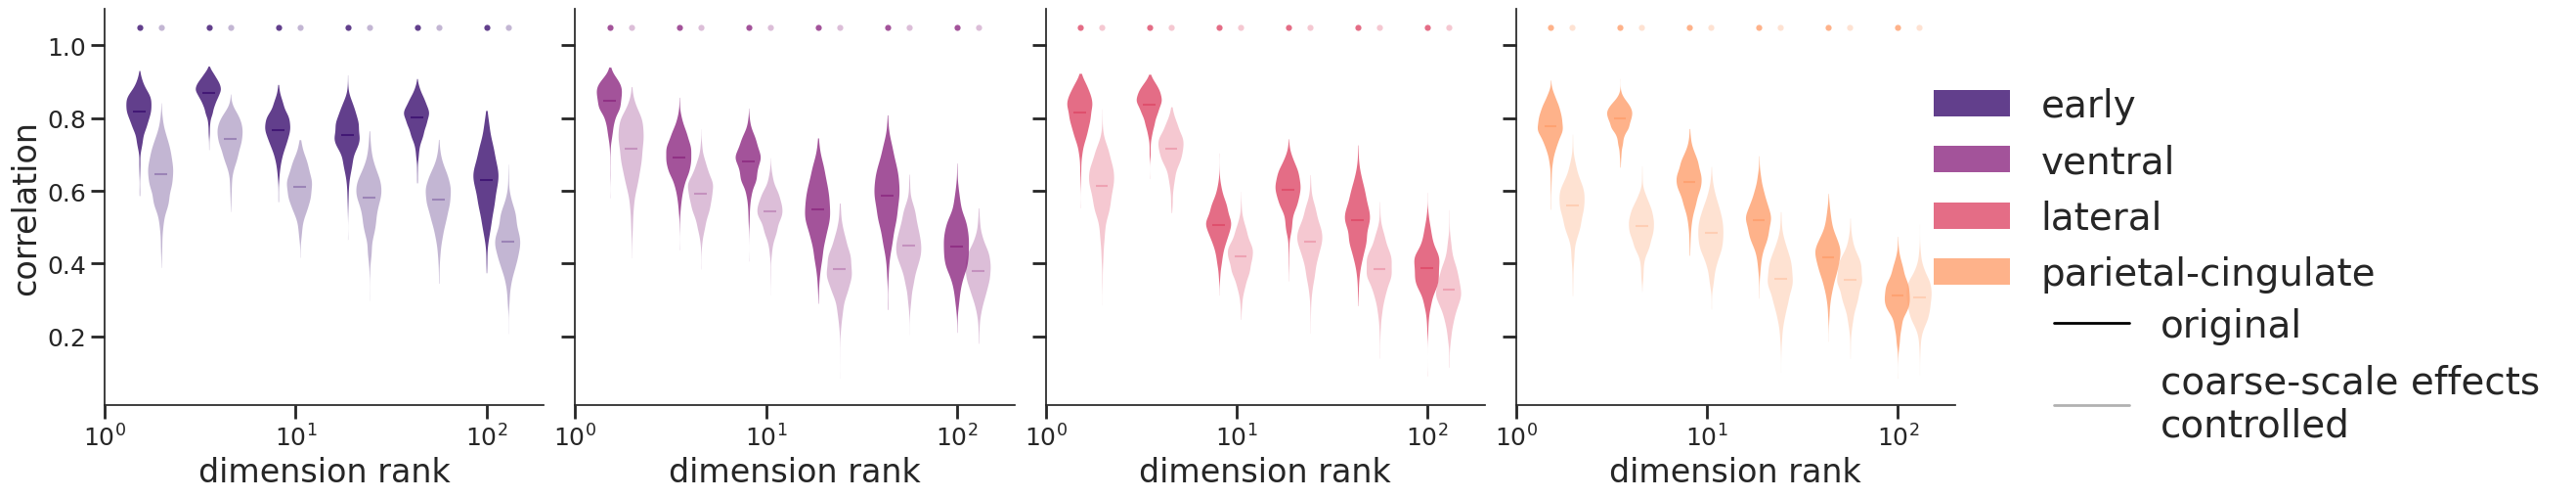

In [13]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

alpha = 0.05
figure, axes = plt.subplots(1, len(rois), figsize=(5*len(rois), 5))
plt.rcParams.update({
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'figure.constrained_layout.use': True,
    'figure.constrained_layout.w_pad': 0.05,
    'figure.constrained_layout.h_pad': 0.05,
})
idm_roi_colors = sns.color_palette("magma", n_colors=len(rois))

for n_roi, roi in enumerate(rois):
    for n_bin, bin in enumerate(unique_bins[:6]):
        samples_isc = np.array([sp[n_bin] for sp in roi_boot_corrs_isc[roi]])
        samples = np.array([sp[n_bin] for sp in roi_boot_corrs[roi]])
        
        pos = bin if bin > 1 else 1 
        
        width = pos * 0.3 
        
        # Create violin plots with adjusted widths
        v1 = axes[n_roi].violinplot(samples_isc, [pos * 1.3], points=100,
                                  widths=[pos * 1.3 * 0.3], 
                                  showmeans=True, showextrema=False)
        v2 = axes[n_roi].violinplot(samples, [pos], points=100,
                                  widths=[width],
                                  showmeans=True, showextrema=False)
        
        # ISC-controlled (solid)
        v1['bodies'][0].set_color(idm_roi_colors[rois.index(roi)])
        v1['bodies'][0].set_alpha(0.3)
        v1['cmeans'].set_color(idm_roi_colors[rois.index(roi)])
        v1['cmeans'].set_alpha(0.3)
        
        # Original correlations (transparent)
        v2['bodies'][0].set_color(idm_roi_colors[rois.index(roi)])
        v2['bodies'][0].set_alpha(0.8)
        v2['cmeans'].set_color(idm_roi_colors[rois.index(roi)])
        v2['cmeans'].set_alpha(0.8)
        
        #Add significance testing if needed
        if bin in significance_isc[roi]:
            axes[n_roi].scatter(pos * 1.3, 1.05, color=idm_roi_colors[n_roi], alpha=0.3, s=20)
        if bin in significance[roi]:
            axes[n_roi].scatter(pos, 1.05, color=idm_roi_colors[n_roi], alpha=0.8, s=20)
          
    axes[n_roi].set_xscale('log')
    axes[n_roi].set_xlabel('dimension rank')
    axes[n_roi].set_xlim(1, 200)
    axes[n_roi].set_ylim(10e-3, 1.10)
    axes[n_roi].tick_params(axis='both', which='major', length=10, width=2)

    if n_roi == 0:
        axes[n_roi].set_ylabel("correlation")
    else:
        axes[n_roi].set_yticklabels([])
        axes[n_roi].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])

legend_elements = [Line2D([0], [0], color='black', lw=2, label='original'),
                   Line2D([0], [0], color='black', lw=2, alpha=0.3, label='coarse-scale effects \ncontrolled')]
figure.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.32, 0.45), fontsize=28)
roi_patches = [Rectangle((0,0), 1, 1, color=idm_roi_colors[i], alpha=0.8) 
                  for i in range(len(rois))]
figure.legend(roi_patches, ['early', 'ventral', 'lateral', 'parietal-cingulate'], 
            bbox_to_anchor=(1.23, 0.9),
            loc='upper right', 
            frameon=False, 
            fontsize=28)

# plt.savefig('/home/chan21/idiosyncratic-neural-geometry/notebooks/figures/figure2.svg', format='svg', dpi=300, transparent=True)
# plt.savefig('/home/chan21/idiosyncratic-neural-geometry/notebooks/figures/figure2.pdf', format='pdf', dpi=300, transparent=True)
plt.show()


In [ ]:
p_values = {roi: [] for roi in rois}
for roi in rois:
    corrs = roi_corrs[roi]
    perm_corrs = roi_perm_corrs[roi]
    for n_bin, bin in enumerate(unique_bins):
        observed = corrs[n_bin]
        permuted = np.array([corr[n_bin] for corr in perm_corrs])
        n_permutations = len(permuted)
        n_exceeding = np.sum(permuted >= observed, axis=0)
        effect_size = (observed - np.mean(permuted)) / np.std(permuted)
        pvalue = n_exceeding / n_permutations
        corrected_pvalue = min(pvalue * len(unique_bins), 1)
        p_values[roi].append(corrected_pvalue)
        print(f"{roi}: {bin} {round(observed, 3)}; {round(effect_size, 3)}; {corrected_pvalue}")
        if corrected_pvalue < 0.05:
            significance[roi].append(bin)
p_values_isc = {roi: [] for roi in rois}
for roi in rois:
    corrs = roi_corrs_isc[roi]
    perm_corrs = roi_perm_corrs_isc[roi]
    for n_bin, bin in enumerate(unique_bins):
        observed = corrs[n_bin]
        permuted = np.array([corr[n_bin] for corr in perm_corrs])
        n_permutations = len(permuted)
        n_exceeding = np.sum(permuted >= observed, axis=0)
        effect_size = (observed - np.mean(permuted)) / np.std(permuted)
        pvalue = n_exceeding / n_permutations
        corrected_pvalue = min(pvalue * len(unique_bins), 1)
        p_values_isc[roi].append(corrected_pvalue)
        print(f"{roi}: {bin} {round(observed, 3)}; {round(effect_size, 3)}; {corrected_pvalue}")
        if corrected_pvalue < 0.05:
            significance_isc[roi].append(bin)

/tmp/ipykernel_3433/3606926941.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3433/3606926941.py:210: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


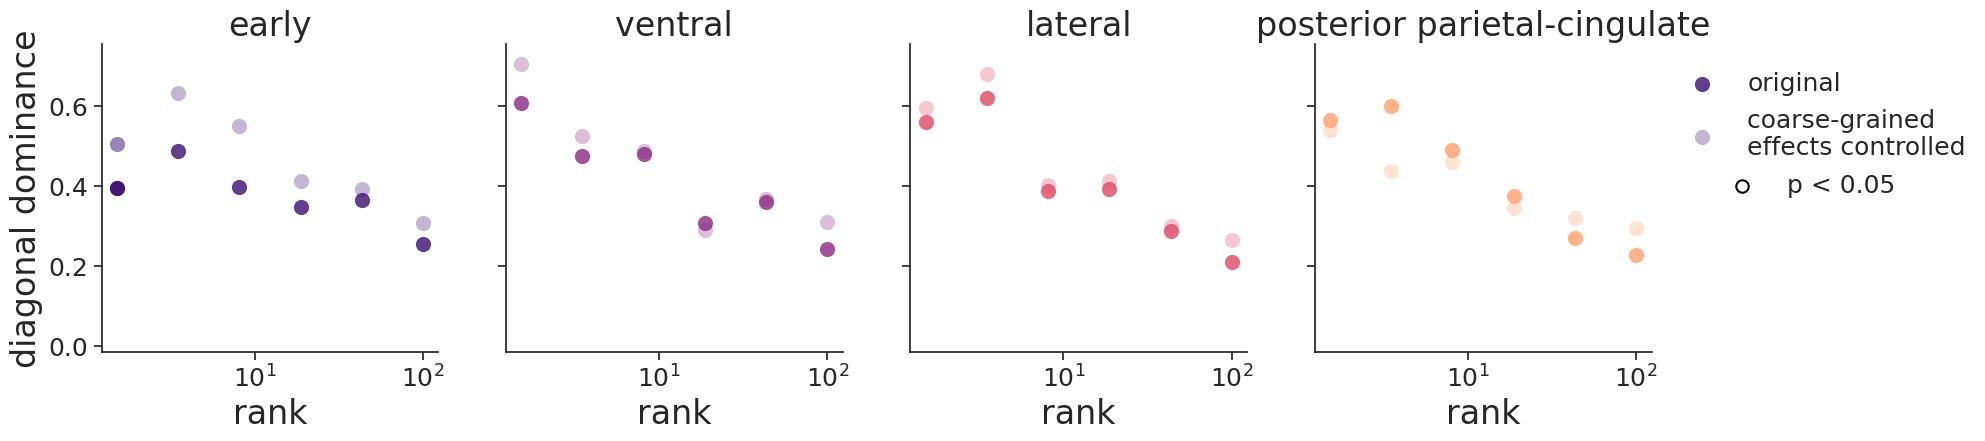

In [14]:
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multitest

def calculate_diagonal_differences(matrix):
    """Calculate diagonal dominance for all bins"""
    n = len(matrix)
    differences = []
    for i in range(n):
        diagonal = matrix[i, i]
        off_diagonals = np.delete(matrix[i], i)
        diff = diagonal - np.mean(off_diagonals)
        differences.append(diff)
    return np.array(differences)

def calculate_significance(observed_diff, permuted_matrices, alpha=0.05):
    """
    Calculate statistical significance of diagonal dominance
    
    Parameters:
    -----------
    observed_diff : numpy.ndarray
        Observed diagonal dominance values (length n_bins)
    permuted_matrices : list
        List of permuted matrices, each with shape (n_bins, n_bins)
    alpha : float
        Significance level (default: 0.05)
        
    Returns:
    --------
    p_values : numpy.ndarray
        p-values for each bin
    """
    n_bins = len(observed_diff)
    n_permutations = len(permuted_matrices)
    
    # Calculate diagonal dominance for each permutation
    permuted_diffs = np.zeros((n_permutations, n_bins))
    for i, perm_matrix in enumerate(permuted_matrices):
        permuted_diffs[i] = calculate_diagonal_differences(perm_matrix)
    
    # Calculate p-values
    p_values = np.zeros(n_bins)
    for i in range(n_bins):
        p_values[i] = (np.sum(permuted_diffs[:, i] >= observed_diff[i]) + 1) / (n_permutations + 1)
    
    return p_values

def create_difference_figure(roi_split_corrs, roi_split_corrs_isc, roi_perm_split_corrs, roi_perm_split_corrs_isc, rois, unique_bins, idm_roi_colors, alpha=0.05):
    """
    Create figure showing diagonal dominance with statistical significance
    
    Parameters:
    -----------
    roi_split_corrs : dict
        Dictionary mapping ROIs to (n_bins, n_bins) matrices for the first condition
    roi_split_corrs_isc : dict
        Dictionary mapping ROIs to (n_bins, n_bins) matrices for the second condition
    roi_perm_split_corrs : dict
        Dictionary mapping ROIs to lists of permuted (n_bins, n_bins) matrices for the first condition
    roi_perm_split_corrs_isc : dict
        Dictionary mapping ROIs to lists of permuted (n_bins, n_bins) matrices for the second condition
    rois : list
        List of ROI names
    unique_bins : numpy.ndarray
        Array of bin values (x-axis)
    idm_roi_colors : list
        List of colors for each ROI
    alpha : float
        Significance level (default: 0.05)
    """
    fig = plt.figure(figsize=(5*len(rois), 4))
    gs = GridSpec(1, len(rois), figure=fig)
    gs.update(wspace=0.2, hspace=0.4)
    major_ticks = np.array([10, 100])

    all_diffs = []
    for data in [roi_split_corrs, roi_split_corrs_isc]:
        for roi in rois:
            all_diffs.append(calculate_diagonal_differences(data[roi]))
    y_min = min([d.min() for d in all_diffs]) - 0.05
    y_max = max([d.max() for d in all_diffs]) + 0.05

    x_offset = 1  
    all_p_values = {}
    for condition in ['PLS', 'PLS|ISC']:
        all_p_values[condition] = {}
        for roi in rois:
            all_p_values[condition][roi] = []
    
    for roi in rois:
        p_values_pls = calculate_significance(
            calculate_diagonal_differences(roi_split_corrs[roi]), 
            roi_perm_split_corrs[roi], 
            alpha=alpha
        )
        
        p_values_pls_isc = calculate_significance(
            calculate_diagonal_differences(roi_split_corrs_isc[roi]), 
            roi_perm_split_corrs_isc[roi], 
            alpha=alpha
        )
        
        all_p_values['PLS'][roi] = p_values_pls
        all_p_values['PLS|ISC'][roi] = p_values_pls_isc
    
    corrected_significant = {}
    for condition in ['PLS', 'PLS|ISC']:
        # Flatten all p-values for this condition
        flat_pvals = np.concatenate([all_p_values[condition][roi] for roi in rois])
        # Apply FDR correction
        reject, pvals_corrected, _, _ = multitest.multipletests(flat_pvals, alpha=alpha, method='fdr_bh')
        
        # Reshape back into per-ROI arrays
        idx = 0
        corrected_significant[condition] = {}
        for roi in rois:
            n_bins = len(all_p_values[condition][roi])
            corrected_significant[condition][roi] = reject[idx:idx+n_bins]
            idx += n_bins
    
    # Create legend handles and labels before plotting
    legend_handles = []
    legend_labels = []
    
    # Second pass: plot with corrected significance
    for col, roi in enumerate(rois):
        ax = fig.add_subplot(gs[0, col])
        
        # Process both conditions
        conditions = [
            ('PLS', roi_split_corrs, x_offset),
            ('PLS|ISC', roi_split_corrs_isc, 1/x_offset)
        ]
        
        for condition_idx, (condition_name, data, offset_factor) in enumerate(conditions):
            observed_diff = calculate_diagonal_differences(data[roi])
            significant = corrected_significant[condition_name][roi]
            
            # Plot differences with offset x values
            for i, (x, y, sig) in enumerate(zip(unique_bins[:6], observed_diff[:6], significant[:6])):
                # Apply offset to x values
                x_plot = x * offset_factor
                
                marker = 'o'
                edgecolor = 'black' if sig else None  # Add black edge for significant points
                linewidth = 1.5 if sig else 0
                color = idm_roi_colors[col]
                
                # Add slight transparency for the second condition
                marker_alpha = 0.8 if condition_name == 'PLS' else 0.3
                
                scatter = ax.scatter(
                    x_plot, y,
                    color=color,
                    s=120,
                    alpha=marker_alpha,
                    marker=marker,
                    edgecolor=edgecolor,
                    linewidth=linewidth
                )
                
                # Add to legend only once (first plot, first point for each condition)
                if col == 0 and i == 0:
                    scatter = ax.scatter(
                        x_plot, y,
                        color=color,
                        s=120,
                        alpha=marker_alpha,
                        marker=marker,
                        edgecolor=edgecolor,
                        linewidth=0
                    )
                    legend_handles.append(scatter)
                    if condition_name == 'PLS':
                        legend_labels.append(f'original')
                    else:
                        legend_labels.append(f'coarse-grained \neffects controlled')
            
        ax.set_xscale('log')
        ax.set_xticks(major_ticks)
        ax.minorticks_off()
        ax.set_xticklabels([f'$10^{int(np.log10(t))}$' for t in major_ticks], fontsize=18)
        ax.set_ylim(y_min, y_max)
        ax.tick_params(axis='both', which='major', labelsize=18)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if col == 0:
            ax.set_ylabel('diagonal dominance', fontsize=24)
        else:
            ax.set_yticklabels([])
            ax.set_yticks([0.2, 0.4, 0.6])
            
        ax.set_xlabel('rank', fontsize=24)
        
        ax.set_title(rois_names[roi], fontsize=24)

    legend_ax = fig.add_axes([0.96, 0.6, 0.05, 0.2])
    legend_ax.axis('off')
    legend_ax.legend(legend_handles, legend_labels, loc='center', frameon=False, fontsize=18)
    
    sig_legend_ax = fig.add_axes([0.92, 0.5, 0.05, 0.05])
    sig_legend_ax.axis('off')
    sig_legend_ax.scatter(0, 0, s=80, color='white', edgecolor='black', linewidth=1.5)
    sig_legend_ax.text(0.05, 0, f'p < {alpha}', va='center', fontsize=18)
    
    plt.tight_layout() 
    return fig

fig_difference = create_difference_figure(roi_split_corrs, roi_split_corrs_isc,
                                        roi_perm_split_corrs, roi_perm_split_corrs_isc,
                                        rois, unique_bins, idm_roi_colors)
#plt.savefig('/home/chan21/idiosyncratic-neural-geometry/notebooks/figures/figure3b_diagonal_significance_dmn_100.svg', dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig('/home/chan21/idiosyncratic-neural-geometry/notebooks/figures/figure3b_diagonal_significance_dmn_100.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

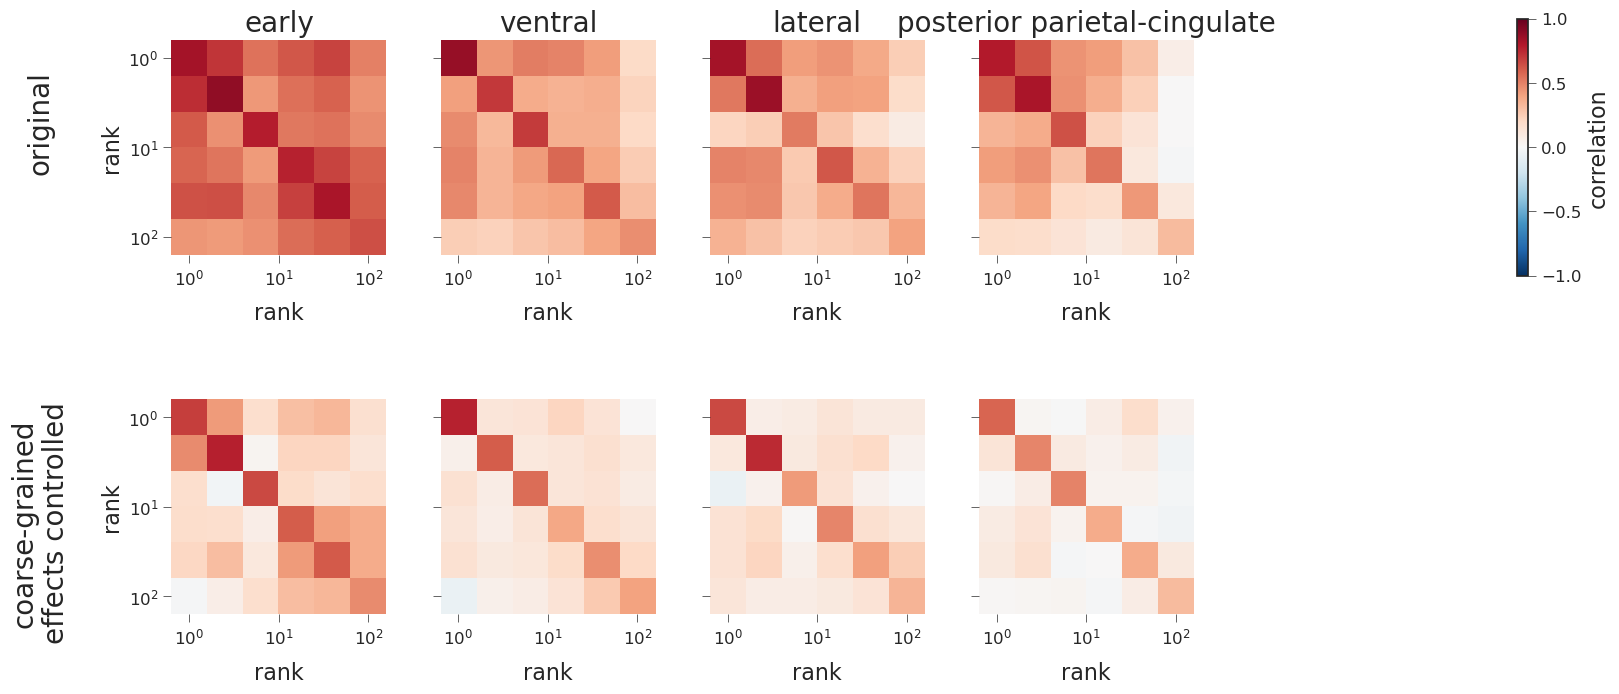

In [15]:
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multitest
from matplotlib.patches import Rectangle

def create_heatmap_figure(roi_split_corrs, roi_split_corrs_isc, rois, rois_names, 
                         roi_perm_split_corrs=None, roi_perm_split_corrs_isc=None, alpha=0.05):
    """
    Create heatmap figure with significance indicators for diagonal elements
    
    Parameters:
    -----------
    roi_split_corrs : dict
        Dictionary mapping ROIs to (n_bins, n_bins) matrices for the first condition
    roi_split_corrs_isc : dict
        Dictionary mapping ROIs to (n_bins, n_bins) matrices for the second condition
    rois : list
        List of ROI names
    rois_names : dict
        Dictionary mapping ROI keys to display names
    roi_perm_split_corrs : dict, optional
        Dictionary mapping ROIs to lists of permuted (n_bins, n_bins) matrices for the first condition
    roi_perm_split_corrs_isc : dict, optional
        Dictionary mapping ROIs to lists of permuted (n_bins, n_bins) matrices for the second condition
    alpha : float
        Significance level (default: 0.05)
    """
    fig = plt.figure(figsize=(17.5, 8))
    gs = GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 1, 1, 1, 0.05])
    gs.update(wspace=0.3, hspace=0.4)
    
    n_bins = next(iter(roi_split_corrs.values())).shape[0]
    log_ticks = np.array([0, 1, 2])  # Powers of 10
    tick_positions = np.interp(log_ticks, [0, 2], [0, 5])
    tick_labels = [f'$10^{int(p)}$' for p in log_ticks]
    
    # Calculate significance if permutation data is provided
    significant_diagonals = {}
    if roi_perm_split_corrs is not None and roi_perm_split_corrs_isc is not None:
        for condition_name, data, perm_data in [
            ('PLS', roi_split_corrs, roi_perm_split_corrs),
            ('PLS|ISC', roi_split_corrs_isc, roi_perm_split_corrs_isc)
        ]:
            significant_diagonals[condition_name] = {}
            
            for roi in rois:
                significant_diagonals[condition_name][roi] = np.ones(n_bins, dtype=bool)
    
    for row in [0, 1]:
        data = roi_split_corrs if row == 0 else roi_split_corrs_isc
        condition_name = 'PLS' if row == 0 else 'PLS|ISC'
        
        for col, roi in enumerate(rois):
            ax = fig.add_subplot(gs[row, col])
            diagonals = data[roi][:6, :6]
            
            off_diag_mean = np.mean([diagonals[i,j] for i in range(len(diagonals))
                                  for j in range(len(diagonals)) if i != j])
            vmax = max(np.max(diagonals), abs(off_diag_mean))
            
            im = ax.imshow(diagonals, cmap='RdBu_r', vmin=-1, vmax=1)
            
            # Add significance indicators for diagonal elements if available
            if roi_perm_split_corrs is not None and roi_perm_split_corrs_isc is not None:
                sig_diags = significant_diagonals[condition_name][roi][:-1]
                for i in range(len(diagonals)):
                    if sig_diags[i]:
                        if i == len(diagonals) - 1:
                            rect = Rectangle(
                                (i - 0.4, i - 0.4), 
                                0.8, 0.8, 
                                linewidth=2,
                                edgecolor='black',
                                facecolor='none'
                            )
                        else:
                            rect = Rectangle(
                                (i - 0.45, i - 0.45), 
                                0.9, 0.9,  
                                linewidth=2,
                                edgecolor='black',
                                facecolor='none'
                            )
                        ax.add_patch(rect)
            
            ax.set_xticks(tick_positions)
            ax.set_yticks(tick_positions)
            ax.set_xticklabels(tick_labels, fontsize=12, fontfamily='Arial')
            
            if col == 0:
                ax.set_yticklabels(tick_labels, fontsize=12, fontfamily='Arial')
                ax.set_ylabel('rank', fontsize=16, fontfamily='Arial')
            else:
                ax.set_yticklabels([])
                
            ax.set_xlabel('rank', labelpad=10, fontsize=16, fontfamily='Arial')
            ax.tick_params(length=6, width=0.5)
            
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)

            if row == 0:
                ax.set_title(rois_names[roi], fontsize=20, fontfamily='Arial')
    
    fig.text(0.05, 0.75, 'original', fontsize=20, fontfamily='Arial', rotation=90, ha='center', va='center')
    fig.text(0.05, 0.25, 'coarse-grained\neffects controlled', fontsize=20, fontfamily='Arial', rotation=90, ha='center', va='center')
    
    cax = fig.add_subplot(gs[0:1, -1])  
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('correlation', fontsize=16, fontfamily='Arial')
    cax.tick_params(labelsize=12, length=6, width=0.5)
    for tick in cax.get_yticklabels():
        tick.set_fontfamily('Arial')
    
    if roi_perm_split_corrs is not None and roi_perm_split_corrs_isc is not None:
        legend_ax = fig.add_axes([0.85, 0.45, 0.1, 0.05]) 
        legend_ax.axis('off')
        legend_ax.add_patch(Rectangle((0.4, 0.65), 0.1, 0.3, linewidth=2, edgecolor='black', facecolor='none'))
        legend_ax.text(0.6, 0.6, f'p < {alpha}', fontsize=12, va='center', fontfamily='Arial')
    
    plt.tight_layout(rect=[0.06, 0, 0.95, 1])
    return fig

fig = create_heatmap_figure(
    roi_split_corrs, 
    roi_split_corrs_isc, 
    rois,
    rois_names,
    alpha=0.05
)
plt.show()
# plt.savefig('/home/chan21/idiosyncratic-neural-geometry/notebooks/figures/figure4.svg', dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig('/home/chan21/idiosyncratic-neural-geometry/notebooks/figures/figure4.pdf', dpi=300, bbox_inches='tight', transparent=True)